In [1]:
import pymysql
import pickle
import json

import math
import numpy as np
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import os
import time
import hdbscan


In [2]:
processed_data_dir = 'track_communities_data_processing/'
figures_dir = 'track_communities_figures/'
save_prefix = 'year_clusters_fract2_sample5'

START_YEAR = 1998  # ~500k total abstracts in dataset
END_YEAR = 2018    #   ~1m total abstracts in dataset
N_years = END_YEAR - START_YEAR + 1

sample_fraction = 0.2  # 0.2  # fraction of total pmids to sample

# pmids for each year (for convenience)
path2dir = '/home/brendan/FastData/pubmed2019/pubmed_data_processing/year_pmids/'  # knowledge-garden



In [3]:
# set up mysql connection

In [4]:

config_path = '/home/brendan/Projects/AttentionWildfires/attention_wildfires/mysql_config.json'
db_name = 'test_pubmed'  # db name collisons? https://stackoverflow.com/questions/14011968/user-cant-access-a-database
                        # todo should move this db_name into config file
with open(config_path, 'r') as f:
    config_data = json.load(f)
    
client_config = {'database': db_name,
                'user': config_data['user'],
                 'password': config_data['lock']}

## init db connection
db = pymysql.connect(**client_config)


In [5]:
# load the pre-fit umap model
#   todo do this in higher dimensionality

In [6]:
print('pop open pickle jar: umap model...')
umap_path = "/home/brendan/FastData/pubmed2019/pubmed_data_processing/dimensionality_reduction_models/umap2D/umap_model0.pkl"
with open(umap_path, 'rb') as file:
    umap_model = pickle.load(file)

pop open pickle jar: umap model...


In [7]:
# helper functions

In [8]:
def load_PMIDs(year):
    '''
    sample pmids from this year
        note: relies on parameters specified above
    '''
    filename = 'pubmed_state_{}'.format(year)
    path2pmids = path2dir + filename
    with open(path2pmids,'r') as f:
        data = json.load(f)

    year_pub_pmids = data['publications']
    N_pubs = len(year_pub_pmids)
    print("N pubs: {}".format(N_pubs))
    del data
    
    K_sample = int(N_pubs * sample_fraction)
    print("K samples: {}".format(K_sample))
    sample_pmids = np.random.choice(year_pub_pmids, K_sample)
    return sample_pmids


In [9]:
def get_embedding_vectors(sample_pmids):
    '''
    get embedding coordinates from database based on PMID list
    '''
    print('fetching embedding vectors from database...')
    start_time = time.time()
        
    str_fmt = ', '.join([str(pmid) for pmid in sample_pmids])
    sql = '''SELECT E.pmid, E.embedding
            FROM scibert_mean_embedding as E
            WHERE E.pmid IN ({})'''.format(str_fmt)
    cursor = db.cursor()
    cursor.execute(sql)
    
    pub_embeddings = []
    pub_pmids = []
    for i,row in enumerate(cursor):
        pub_pmids.append(row[0])
        pub_embeddings.append(np.frombuffer(row[1],dtype='float16').tolist())
    cursor.close()
    
    end_time = time.time()
    elapsed = end_time - start_time
    print("SQL query composed and executed in {} s".format(elapsed))
    
    return pub_pmids, pub_embeddings

def get_compressed_embedding_vectors(sample_pmids):
    '''
    calls get_embedding vectors
    then runs dimensionality reduction
    '''
    
    # return the pmids which have corresponding embeddings
    pmids, embeddings = get_embedding_vectors(sample_pmids)    
    print('compressing embedding vectors...')
    
    return pmids, umap_model.transform(embeddings)

In [10]:
R_MAX = 10
def serialize_point(x,y):
    '''
    take a point in R2 and assign a score,
        resulting in an ordering of points on the plane
    '''
    theta = math.atan2(x,y)
    theta = theta / math.pi # rescale onto (-1,1)
    if theta < 0:  # restitch 0-angle
        theta = theta + 2
    theta = round(theta,1) # limit precision of theta and break ties with r
    r = math.sqrt(x*x + y*y)
    r = r / R_MAX  # rescale onto (0,1)
    score = 10*theta + r  # use angle first, break ties with radius
    return score

def normalize_cluster_labels(xx, yy, old_labels):
    '''
        take a set of old labels and positions
        return a set of labels assigned in a fixed order, 
            for easer comparison downstream
    '''
    
    # number of clusters
    N_clusters = int(old_labels.max()+1)
    print('num clusters: {}'.format(N_clusters))
    
    # get summary coordinate for each cluster
    cluster_median = np.zeros( (N_clusters, 2))  # x,y (would be better to use median though)
    for i_cluster in range(N_clusters):
        total_points = 0
        vector_sum = np.zeros((1,2))
        
        convenience_xx, convenience_yy = [], []
        for i_label, label in enumerate(old_labels):
            # do nothing for labels of -1
            if label==i_cluster:
                convenience_xx.append(xx[i_label])
                convenience_yy.append(yy[i_label])
                
        median_x = np.median(convenience_xx)
        median_y = np.median(convenience_yy)
        cluster_median[i_cluster,:] = (median_x, median_y) 
    
    # use summary coordinate to order the clusters based on a serialization function
    cluster_scores = []
    for i_cluster in range(N_clusters):
        score = serialize_point(cluster_median[i_cluster,0],
                               cluster_median[i_cluster,1])
        cluster_scores.append(score)
        
    # sort ascending
    print(cluster_scores)
    new_labels = np.argsort(np.argsort(cluster_scores))
    print(new_labels)   
    
    # re-assign labels after normalizing integer names for consistency
    num_samples = len(old_labels)
    newlabels_ = np.zeros( (num_samples,) ).astype(int)
    for i_label, old_label in enumerate(old_labels):
        if old_label==-1:
            newlabels_[i_label] = -1  # populate new labels
        else:
            newlabels_[i_label] = new_labels[int(old_label)]  # cast as integer (temp hack)
    
    return newlabels_
        

In [11]:
def plot_clustering(xx, yy, labels, title):
    unique_labels = np.unique(labels)
    cluster_cmap = plt.cm.viridis(np.linspace(0,1,len(unique_labels)+1))
    
    (f, axs) = plt.subplots(1,
                            3,
                           sharex='all',
                           sharey='all',
                           figsize=(12,4))
    
    #kwargs = {'levels': np.arange(0, 0.05, 0.001)}  # specify bins for colormaps
        
    # plot full distribution on 1st subplot
    sns.kdeplot(xx,
                yy,
                n_levels=100,
                shade=True,
                shade_lowest=True,
                color=[0.1, 0.1, 0.1, 1.0],
                ax=axs[0],
                vmin=0,
                vmax=0.05,
                cbar=False,
                cbar_kws={'orientation':'horizontal'})
    axs[0].set_title('{}'.format(title))
    axs[0].set_xlabel('umap dim 0')
    axs[0].set_ylabel('umap dim 1')
    
    # plot full distribution on 2nd subplot
    sns.kdeplot(xx,
                yy,
                n_levels=100,
                shade=True,
                shade_lowest=True,
                color=[0.1, 0.1, 0.1, 1.0],
                ax=axs[1],
                vmin=0,
                vmax=0.05,
                cbar=False,
                cbar_kws={'orientation':'horizontal'})
    axs[1].set_xlabel('umap dim 0')
    axs[1].set_ylabel('umap dim 1')
        
        
    # plot clusters on 2nd subplot    
    #   i.e. clusters 0 through N_clusters
    for i_label, label in enumerate(unique_labels):
        
        if label >= 0:
                
            xx_ = [x for (i,x) in enumerate(xx) if labels[i]==label]
            yy_ = [y for (i,y) in enumerate(yy) if labels[i]==label]
            
            # outlines superimposed
            sns.kdeplot(xx_,
                        yy_,
                        n_levels=2,
                        shade=False,
                        color=cluster_cmap[i_label],
                        ax=axs[1],
                        cbar=False)

            #if label==0:  # show a colorbar for the first cluster (note, changed this)
            sns.kdeplot(xx_,
                        yy_,
                        n_levels=10,
                        shade=True,
                        shade_lowest=False,
                        color=cluster_cmap[i_label],
                        ax=axs[2],
                        cbar=False,
                        cbar_kws={'orientation':'horizontal'})
            
            axs[2].set_xlabel('umap dim 0 (a.u.)')
            axs[2].set_ylabel('umap dim 1 (a.u.)')
            '''
            else:  # don't show colorbars for the other clusters
                sns.kdeplot(xx_,
                            yy_,
                            n_levels=10,
                            shade=True,
                            shade_lowest=False,
                            color=cluster_cmap[i_label],
                            ax=axs[1])
            '''
        
    # plot distribution of non-clustered samples on 3rd subplot
    #    i.e. the -1 labeled clusters
    '''
    xx_ = [x for (i,x) in enumerate(xx) if labels[i]==-1]
    yy_ = [y for (i,y) in enumerate(yy) if labels[i]==-1]
    sns.kdeplot(xx_,
                yy_,
                n_levels=100,
                shade=True,
                shade_lowest=True,
                color=[0.1, 0.1, 0.1, 1.0],
                ax=axs[2],
                cbar=True,
                cbar_kws={'orientation':'horizontal'})
    axs[2].set_title('{}: remainder'.format(title))
    '''
    
    plt.savefig('{}.png'.format(title))
    plt.savefig('{}.eps'.format(title))
    
    
        
        

In [12]:
# load pmids, sample, cluster

In [13]:
year_data = {}
year_data['dimensionality_reduction'] = umap_path  # version of dimensionality reduction used
year_data['sample_fraction'] = 0.2
'''
year_data
    dim_reduction - e.g. umap version
    year
        sample_pmids

'''

for i_year, year in enumerate(range(START_YEAR, END_YEAR+1)):
    print("year {}".format(year))
    year_data[year] = {} # init data structure
    
    # get sample PMIDs published this year
    sample_pmids = load_PMIDs(year)  # some of these don't have abstracts
    (pmids, embeddings) = get_compressed_embedding_vectors(sample_pmids)
    print("N abstracts fetched: {}".format(len(pmids)))
    year_data[year]['sample_pmids'] = np.copy(pmids).tolist()
    year_data[year]['embedding'] = np.copy(embeddings).tolist()


year 1998
N pubs: 474479
K samples: 94895
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 216.23590540885925 s
compressing embedding vectors...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../brendanchambers/.conda/envs/embedding-base/lib/python3.7/site-packages/umap/nndescent.py", line 123:
<source missing, REPL/exec in use?>

  state.func_ir.loc))
/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../brendanchambers/.conda/envs/embe

N abstracts fetched: 63173
year 1999
N pubs: 493485
K samples: 98697
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 175.61044359207153 s
compressing embedding vectors...
N abstracts fetched: 64392
year 2000
N pubs: 530246
K samples: 106049
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 196.2130675315857 s
compressing embedding vectors...
N abstracts fetched: 71651
year 2001
N pubs: 543554
K samples: 108710
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 161.58414673805237 s
compressing embedding vectors...
N abstracts fetched: 75624
year 2002
N pubs: 558647
K samples: 111729
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 217.99534678459167 s
compressing embedding vectors...
N abstracts fetched: 78660
year 2003
N pubs: 583939
K samples: 116787
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 194.24556922912598 s
compressing embedding vectors...
N abstracts fetched: 81726
year 2004
N pubs: 619853
K samples: 123970
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 223.09697484970093 s
compressing embedding vectors...
N abstracts fetched: 88791
year 2005
N pubs: 656109
K samples: 131221
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 188.58043599128723 s
compressing embedding vectors...
N abstracts fetched: 94559
year 2006
N pubs: 684653
K samples: 136930
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 200.17309880256653 s
compressing embedding vectors...
N abstracts fetched: 97146
year 2007
N pubs: 710132
K samples: 142026
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 191.96682572364807 s
compressing embedding vectors...
N abstracts fetched: 102081
year 2008
N pubs: 750874
K samples: 150174
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 190.1944932937622 s
compressing embedding vectors...
N abstracts fetched: 111747
year 2009
N pubs: 784150
K samples: 156830
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 171.73809719085693 s
compressing embedding vectors...
N abstracts fetched: 116500
year 2010
N pubs: 822964
K samples: 164592
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 148.3491711616516 s
compressing embedding vectors...
N abstracts fetched: 120789
year 2011
N pubs: 875685
K samples: 175137
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 150.76361989974976 s
compressing embedding vectors...
N abstracts fetched: 125990
year 2012
N pubs: 939925
K samples: 187985
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 137.1641490459442 s
compressing embedding vectors...
N abstracts fetched: 141498
year 2013
N pubs: 994460
K samples: 198892
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 208.6227560043335 s
compressing embedding vectors...
N abstracts fetched: 147882
year 2014
N pubs: 1041775
K samples: 208355
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 187.7919135093689 s
compressing embedding vectors...
N abstracts fetched: 155296
year 2015
N pubs: 1089303
K samples: 217860
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 188.36689496040344 s
compressing embedding vectors...
N abstracts fetched: 162290
year 2016
N pubs: 1110653
K samples: 222130
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 203.8910689353943 s
compressing embedding vectors...
N abstracts fetched: 168240
year 2017
N pubs: 1120990
K samples: 224198
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 178.48483443260193 s
compressing embedding vectors...
N abstracts fetched: 166778
year 2018
N pubs: 1205220
K samples: 241044
fetching embedding vectors from database...


/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (3170, "Memory capacity of 8388608 bytes for 'range_optimizer_max_mem_size' exceeded. Range optimization was not done for this query.")
  result = self._query(query)


SQL query composed and executed in 230.79838299751282 s
compressing embedding vectors...
N abstracts fetched: 168313


In [14]:
target_path = processed_data_dir + save_prefix + '_samples.json'

with open(target_path,'w') as f:
    json.dump(year_data, f)  # already turned numpy to lists
    
# send back to numpy array
for i_year, year in enumerate(range(START_YEAR, END_YEAR+1)):
    year_data[year]['embedding'] = np.asarray(year_data[year]['embedding'])

In [15]:
# cluster the compressed embeddings

clusterers = {}
for i_year, year in enumerate(range(START_YEAR, END_YEAR+1)):
    print("year {}".format(year))
    
    pmids = year_data[year]['sample_pmids']
    clustering_scale = int(len(pmids) * 0.005)
    min_samples = int(len(pmids) * 0.001)
    min_samples_param = int(np.min([1000, min_samples])) # hdbscan can't handle really big values here
    print("scale: {}  | min_samples: {} ".format(clustering_scale, min_samples_param))
    ####################
    clusterers[i_year] = hdbscan.HDBSCAN(min_cluster_size=clustering_scale, # 500 for 25K # 1000 for 50K # 50 fro 2000
                            min_samples=min_samples_param,   # 500, 1000, 50
                            cluster_selection_method='leaf') # eom')  # euclidean distance
    clusterers[i_year].fit(year_data[year]['embedding'])  # samples x features

    # number of clusters
    print('num clusters: {}'.format(clusterers[i_year].labels_.max()+1))
    



year 1998
scale: 315  | min_samples: 63 
num clusters: 28
year 1999
scale: 321  | min_samples: 64 
num clusters: 31
year 2000
scale: 358  | min_samples: 71 
num clusters: 27
year 2001
scale: 378  | min_samples: 75 
num clusters: 27
year 2002
scale: 393  | min_samples: 78 
num clusters: 31
year 2003
scale: 408  | min_samples: 81 
num clusters: 34
year 2004
scale: 443  | min_samples: 88 
num clusters: 31
year 2005
scale: 472  | min_samples: 94 
num clusters: 38
year 2006
scale: 485  | min_samples: 97 
num clusters: 34
year 2007
scale: 510  | min_samples: 102 
num clusters: 37
year 2008
scale: 558  | min_samples: 111 
num clusters: 31
year 2009
scale: 582  | min_samples: 116 
num clusters: 30
year 2010
scale: 603  | min_samples: 120 
num clusters: 31
year 2011
scale: 629  | min_samples: 125 
num clusters: 29
year 2012
scale: 707  | min_samples: 141 
num clusters: 30
year 2013
scale: 739  | min_samples: 147 
num clusters: 27
year 2014
scale: 776  | min_samples: 155 
num clusters: 28
year 2

In [16]:
# normalize cluster labels

for i_year, year in enumerate(range(START_YEAR, END_YEAR+1)):
    
    xx = year_data[year]['embedding'][:,0]
    yy = year_data[year]['embedding'][:,1]
    
    new_labels = normalize_cluster_labels(xx,
                                          yy,
                                          clusterers[i_year].labels_)

    # overwrite old labels with normalized labels
    for i_label, old_label in enumerate(clusterers[i_year].labels_):  # rewrite with new labels
        clusterers[i_year].labels_[i_label] = new_labels[i_label]

num clusters: 28
[7.43743741533458, 5.432553516218762, 4.587709508450345, 18.439784197398218, 18.375715723876002, 10.292608901877625, 17.22075228604901, 6.241041279157855, 11.4790120102052, 4.494079354461595, 6.109003309256965, 12.485005697917185, 12.350272798492961, 16.49716140306881, 17.367502424753848, 16.43261440059413, 15.5104632108354, 15.412533573715537, 15.354233237063317, 15.156343337940902, 20.37709906302615, 14.187658140273182, 18.06527466107674, 1.1438384389847103, 1.3924191418875353, 3.4581916364120104, 2.1674941642063987, 2.2660990855546745]
[10  7  6 26 25 11 22  9 12  5  8 14 13 21 23 20 19 18 17 16 27 15 24  0
  1  4  2  3]
num clusters: 31
[4.589666630662445, 18.44371071562124, 18.377665825916285, 7.437151812782279, 5.437671256819572, 9.165076076178025, 10.278882282126022, 12.491468305628231, 6.238730616014485, 6.109814290155663, 11.482894421387716, 12.350297817967272, 19.238793350726937, 17.364850574230914, 16.227036498312543, 14.169215422296862, 14.291318203264408, 

[18.479640973653158, 18.370047854631263, 5.653921607126032, 5.673360618144671, 10.282432702872626, 6.131320037009638, 6.256348312355369, 7.396354576786033, 3.42476741209557, 4.516598818040043, 17.364921731551945, 5.4229221968479155, 14.50119334796572, 15.380956484312406, 16.44489181218429, 16.507165697404265, 6.349994194464027, 6.55479973676809, 5.478660043910976, 5.541120561081662, 17.231223890381013, 19.261479878162124, 20.387893547804445, 2.4554523447187684, 1.290294330890007, 1.4181325256818706, 13.216342943953805, 14.25371369530826, 13.373330530800098, 11.493273146911829, 12.470586902445248]
[28 27  8  9 15 10 11 14  3  4 26  5 21 22 23 24 12 13  6  7 25 29 30  2
  0  1 18 20 19 16 17]
num clusters: 29
[18.3704608531854, 18.48318507458323, 5.653620770169861, 6.1255653072399125, 10.28230393097344, 5.66491470453384, 3.4213213136918554, 4.494657067093957, 7.391591866946387, 17.36452267450581, 4.329579950232516, 6.5305284947533195, 6.255060786640128, 6.348819963678834, 5.4236844276660

In [17]:
    # TODO
    # measure center, radius, # pmids

/home/brendan/anaconda3/envs/embedding-feb2020/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


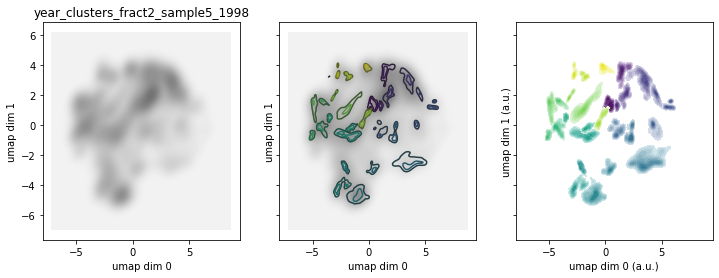

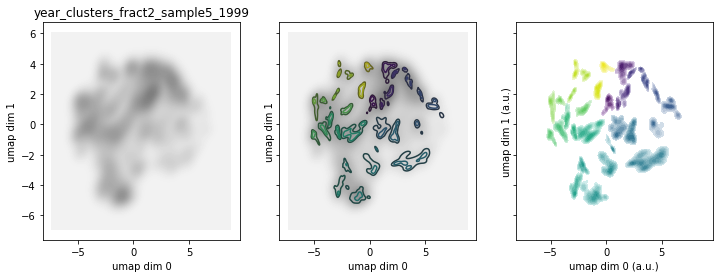

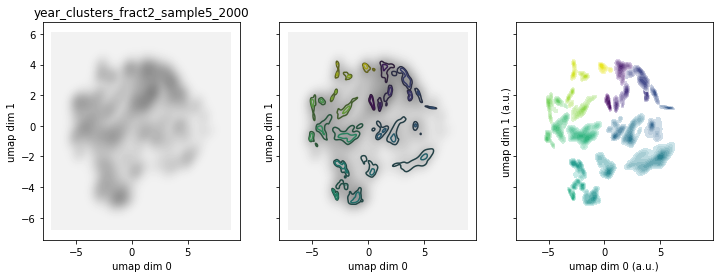

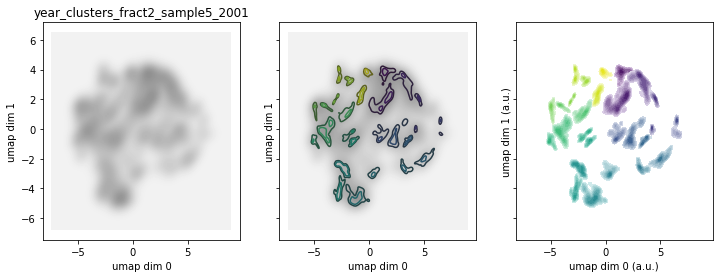

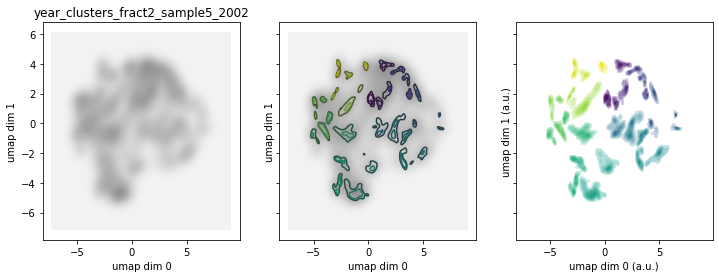

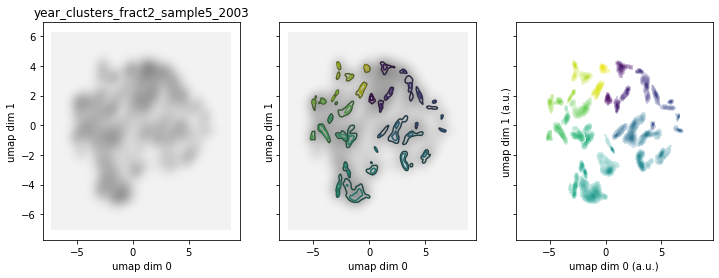

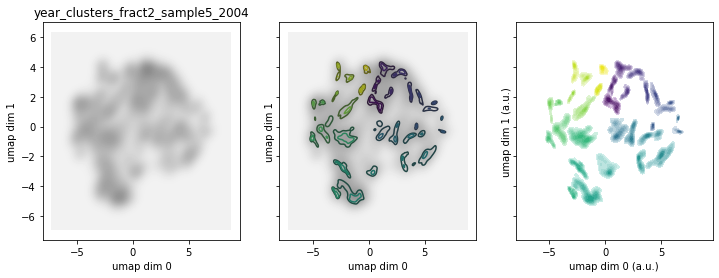

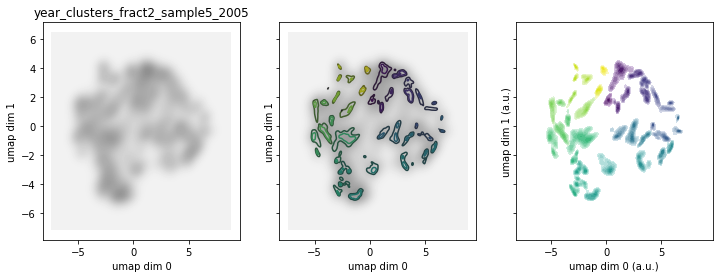

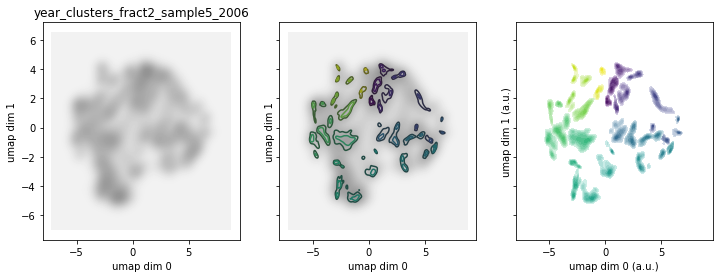

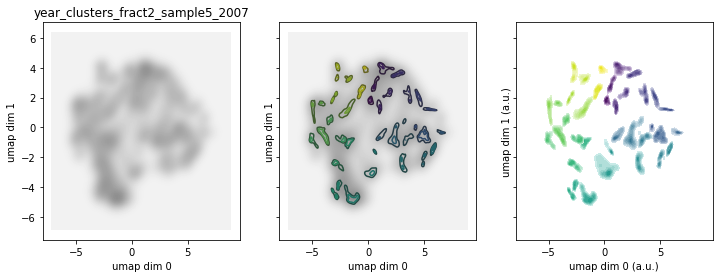

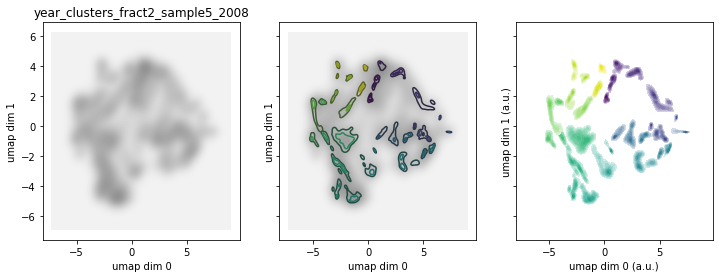

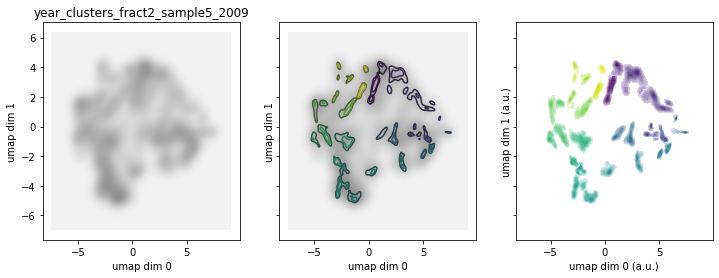

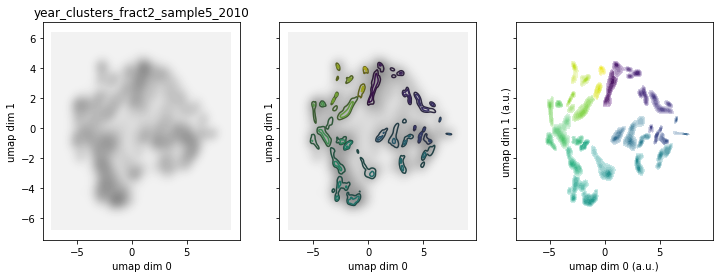

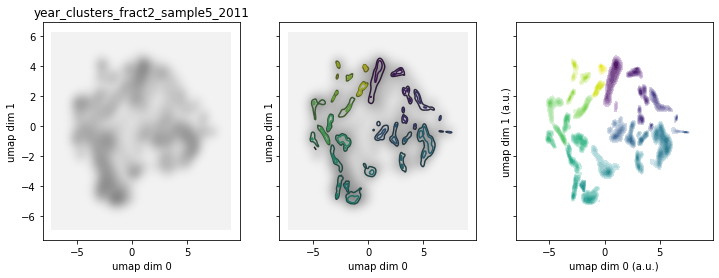

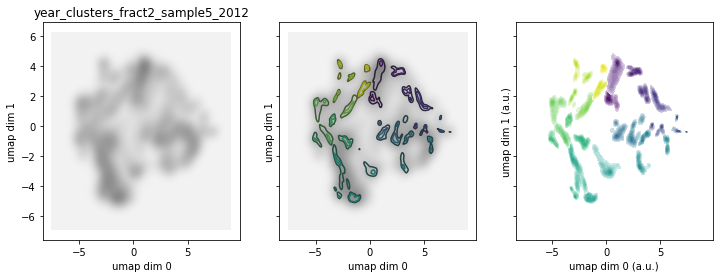

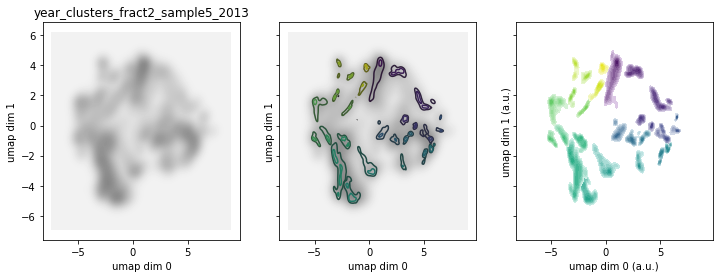

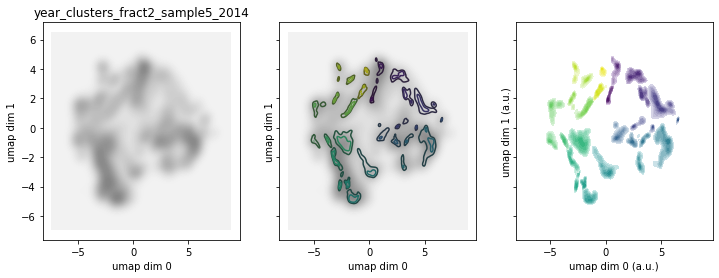

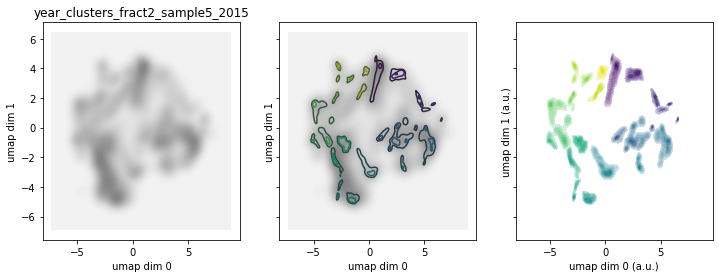

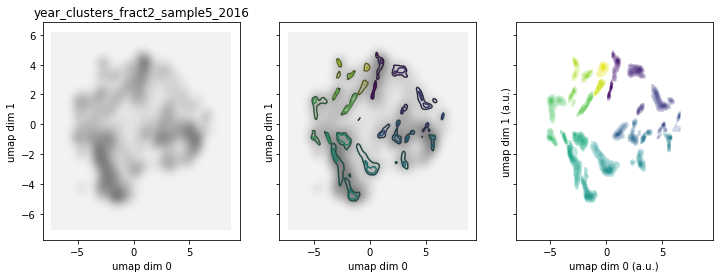

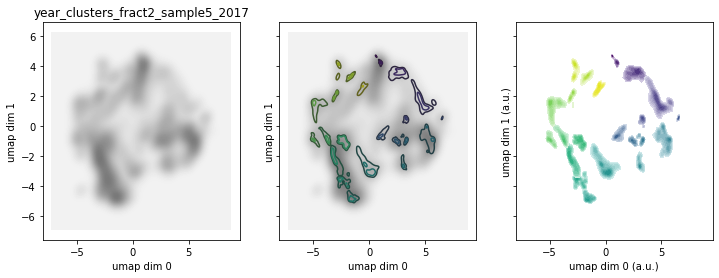

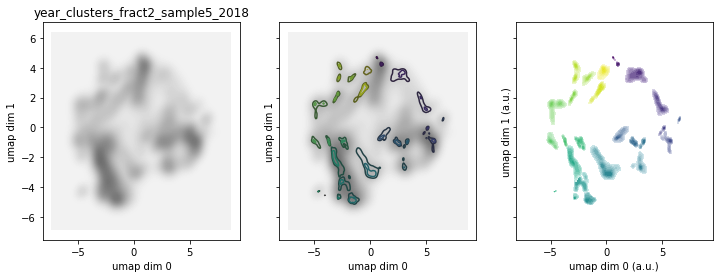

In [18]:
# plot clusters

for i_year, year in enumerate(range(START_YEAR, END_YEAR+1)):
    
    xx = year_data[year]['embedding'][:,0]
    yy = year_data[year]['embedding'][:,1]
    
    title = '{}_{}'.format(save_prefix, year)
    plot_clustering(xx,yy,clusterers[i_year].labels_, title)
    
    

In [19]:
# save things

#target_path = os.path.join(target_prefix, 'clusterers.json')
#with open(target_path,'w') as f:
#    json.dump(clusterers, f)

for i_year, year in enumerate(range(START_YEAR, END_YEAR+1)):
    print(i_year, year)
    year_data[year]['labels'] = clusterers[i_year].labels_.tolist()
    try:
        year_data[year]['embedding'] = year_data[year]['embedding'].tolist()
    except:
        print('embedding is already a list')
    try:
        year_data[year]['sample_pmids'] = year_data[year]['sample_pmids'].tolist()
    except:
        print('sample_pmids is already a list')
    
target_path = processed_data_dir + save_prefix + '_samples.json'
with open(target_path,'w') as f:
    json.dump(year_data, f)
    
print('success!')

0 1998
sample_pmids is already a list
1 1999
sample_pmids is already a list
2 2000
sample_pmids is already a list
3 2001
sample_pmids is already a list
4 2002
sample_pmids is already a list
5 2003
sample_pmids is already a list
6 2004
sample_pmids is already a list
7 2005
sample_pmids is already a list
8 2006
sample_pmids is already a list
9 2007
sample_pmids is already a list
10 2008
sample_pmids is already a list
11 2009
sample_pmids is already a list
12 2010
sample_pmids is already a list
13 2011
sample_pmids is already a list
14 2012
sample_pmids is already a list
15 2013
sample_pmids is already a list
16 2014
sample_pmids is already a list
17 2015
sample_pmids is already a list
18 2016
sample_pmids is already a list
19 2017
sample_pmids is already a list
20 2018
sample_pmids is already a list
success!


In [20]:
# figure todo - dark background on clusters
#    average subtraction over multiple samples?